# dN/dR Distributions from sample galaxy SEDs

Purpose of this notebook is to look at how the dN/dR profile changes when accounting for real galaxy SEDs, as compared to a flat dNdR distribution which was assumed in some previous analysis

05/23/2025




In [42]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import galsim
import os



Text(0, 0.5, 'relative refraction')

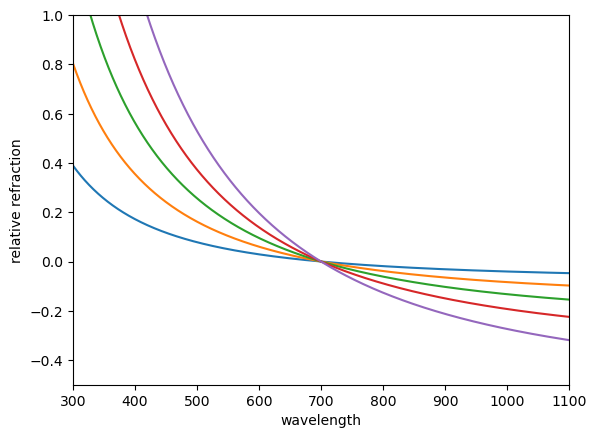

In [43]:
#checking my understanding of the dcr.get_refraction function by 
#recreating the plot 1 from the Impact of Atmospheric Chromatic Effects on Weak Lensing Measurements
zeniths = [10, 20, 30, 40, 50]
# zeniths = [35]
dwvl = 0.5
wavelengths = np.arange(290, 1160, dwvl)

for zenith in zeniths:
    refraction = galsim.dcr.get_refraction(
            wavelengths,
            zenith_angle=zenith * galsim.degrees,
            pressure=70.0,  # kPa
            temperature=293.15,  # K
            H2O_pressure=0.0,  # kPa
            ) * 180 * 3600 / np.pi #convert from radians to arcsec
    
    refraction_0 = galsim.dcr.get_refraction(
            700,
            zenith_angle=zenith * galsim.degrees,
            pressure=70.0,  # kPa
            temperature=293.15,  # K
            H2O_pressure=0.0,  # kPa
            ) * 180 * 3600 / np.pi #convert from radians to arcsec

    
    dR_dwvl = (refraction[1:] - refraction[0:-1])/dwvl
    wavelengths_midpoints = wavelengths[0:-1] + dwvl/2
    
    plt.plot(wavelengths, refraction - refraction_0)
    # plt.plot(wavelengths_midpoints, dR_dwvl, '--')

plt.xlim(300, 1100)
plt.ylim(-0.5, 1)
plt.xlabel('wavelength')
plt.ylabel('relative refraction')



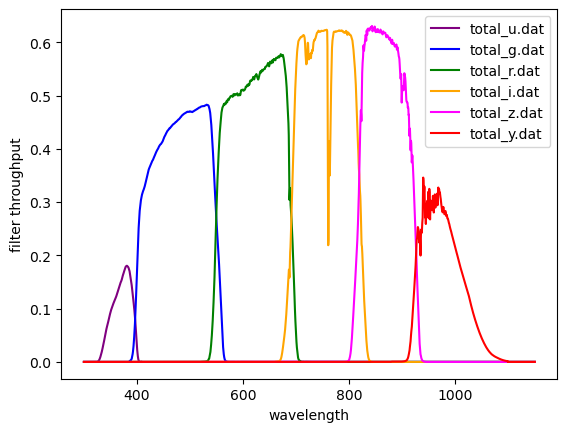

In [58]:
#plot the throughput of each filter
filters = ['total_u.dat','total_g.dat','total_r.dat','total_i.dat','total_z.dat','total_y.dat']
colors = {'u' : 'purple', 'g':'blue', 'r': 'green', 'i': 'orange', 'z' : 'magenta', 'y' : 'red'}
script_dir = os.getcwd()
folder = os.path.join(script_dir, 'filter_files/')
for i, filter_ in enumerate(filters):
    path = folder + filter_
    data = np.loadtxt(path).T
    band = list(colors.keys())[i]
    plt.plot(data[0], data[1], label = filter_, color = colors[band])

plt.xlabel('wavelength')
plt.ylabel('filter throughput')
plt.legend()
plt.show()

Text(0.5, 0, 'wavelength')

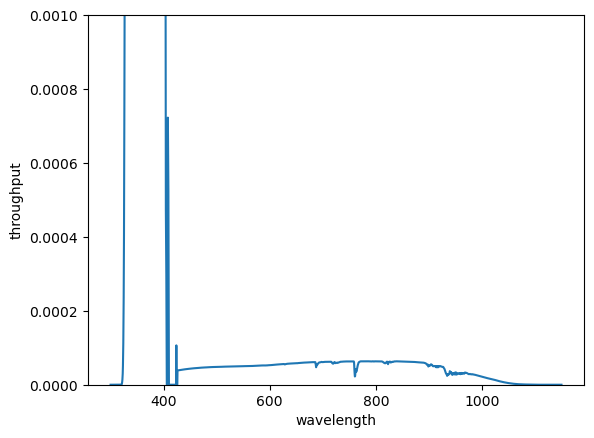

In [45]:
#Examine the throughput in the regions where we expect it to be 0 (leakage)
#might need to force it to be zero if the files contain too much leakage
temp = np.loadtxt('filter_files/total_u.dat').T
plt.plot(temp[0], temp[1])
# plt.yscale('log')
plt.ylim(0, 0.001)
plt.ylabel('throughput')
plt.xlabel('wavelength')






#### Before applying the filters, removed leakage from the filters by removing anything below a 0.001 throughput:

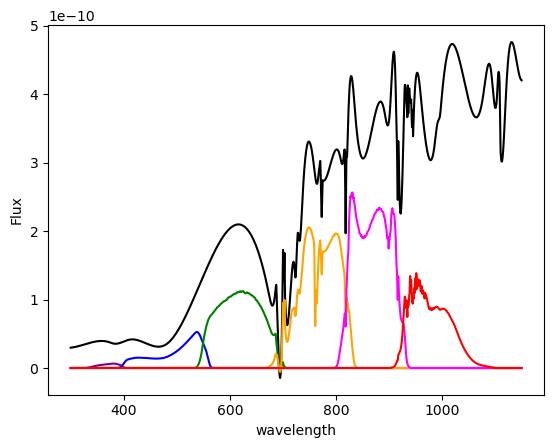

In [59]:
#Open the SED file (contains 1000 randomly sampled SEDs with magnitudes less than 26) and apply the filters

from scipy.interpolate import interp1d

def apply_filter(wvl, data, band = 'g', rm_leakage = True):
    '''
    wvl - a list of the wavelengths in angstroms
    data - a N x M list of SEDs, N = number of SEDs, M = len of wvl
    returns data with the band filter applied to each SED
    '''
    
    filter_file = f'filter_files/total_{band}.dat'
    filter_band = np.loadtxt(filter_file).T #filter_band[0] -> wavelengths, filter_band[1] -> filter pass fraction

    #remove filter leakage: set lower bound of filter to 0.001 throughput
    if rm_leakage:
        leakage_mask = filter_band[1] < 0.001
        filter_band[1][leakage_mask] = np.zeros(np.sum(leakage_mask))
    
    func = interp1d(filter_band[0], filter_band[1])
    SED_filter = func(wvl)
    
    return data * SED_filter
    

#Load the raw sample SEDs
file = '1000SEDs.txt'
data = np.loadtxt(file)
wvl = data[0]
SEDs = data[1:]


#remove wavelengths > 1150 because that's where our filters cut off
mask = wvl < 1150
wvl = wvl[mask]
SEDs = SEDs[:, mask]


# increase wavelength resolution to capture filter details:
func = interp1d(wvl, SEDs)
wvl_temp = np.linspace(min(wvl), max(wvl), 8500)
wvl = wvl_temp
SEDs = func(wvl_temp)

    
filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']

filtered_data = {}

i = 0 #choose the index of one of the SEDs to plot 

plt.plot(wvl, SEDs[i], 'k')

for band in filter_labels:
    filtered_data_i = apply_filter(wvl, SEDs, band)
    filtered_data[band]= apply_filter(wvl, SEDs, band)
    plt.plot(wvl, filtered_data_i[i], color = colors[band])

plt.xlabel('wavelength')
plt.ylabel('Flux')
plt.show()

## Apply refraction effects at a chosen zenith and atmospheric conditions

At a given zenith, there is a 1-to-1 mapping of wavelengths to refraction angles.
Therefore we can go from our filtered flux distributions (dN/dwavelength) to dN/dR by doing the following:

dN/dR = dN/dwavelength * dwavelength/dR

Start by calculating dwavelength/dR as a function of wavelength then multiply this by each of our SEDs:


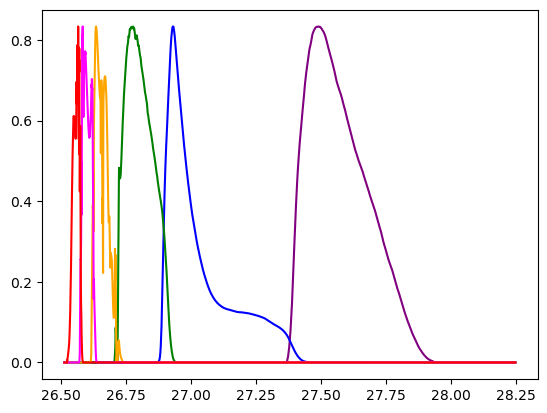

In [61]:

zenith = 35 #degrees
dwvl = 0.1 #wavelength step
wavelengths = np.arange(290, 1160, dwvl)

#Matthew's atmospheric conditions
pressure=70.0,  # kPa
temperature=293.15,  # K
H2O_pressure=0.0,

#Pat and Josh's paper atmospheric conditions 
pressure=69.328
temperature=293.15
H2O_pressure=1.067


#Get dR/dwavelength function
refraction = galsim.dcr.get_refraction(
        wavelengths,
        zenith_angle=zenith * galsim.degrees,
        pressure=pressure,  # kPa
        temperature=temperature,  # K
        H2O_pressure=H2O_pressure,  # kPa
        ) * 180 * 3600 / np.pi #convert from radians to arcsec

dR_dwvl = (refraction[1:] - refraction[0:-1])/dwvl
wavelengths_midpoints = wavelengths[0:-1] + dwvl/2

dRdwvl_func = interp1d(wavelengths_midpoints, dR_dwvl)



#Get the refraction angle of each wavelength in our SEDs
refraction_wave = galsim.dcr.get_refraction(
        wvl,
        zenith_angle=zenith * galsim.degrees,
        pressure=pressure,  # kPa
        temperature=temperature,  # K
        H2O_pressure=H2O_pressure,  # kPa
        ) * 180 * 3600 / np.pi #convert from radians to arcsec


filtered_refracted_data = {} #dictionary which will store dN/dR 

for band, data in filtered_data.items():
    filtered_refracted_data[band] = np.abs(data / dRdwvl_func(wvl))
    
    #example SED to plot
    example_refract_R = data[i] / dRdwvl_func(wvl)
    
    #plot normalized dNdR as a function of refraction
    plt.plot(refraction_wave, np.abs(example_refract_R)/max(np.abs(example_refract_R))/ 1.2, color = colors[band]) 

    ##plot dNdR as a function of wavelength
    # plt.plot(wvl, np.abs(example_refract_R))
    

In [36]:
#Calculate the mean and standard deviation of the refraction angle distributions for each of the SEDs in each filter

refrac_angle_temp = np.array(refraction_wave).T #create a vertical array for purposes of matrix multiplication below

means = {}
stdevs = {}
for band, distribution in filtered_refracted_data.items():
    
    #Weighted mean refraction angles within a single band for each SED
    mean = np.sum(distribution * refrac_angle_temp, axis = 1)/np.sum(distribution, axis =1)

    means[band] = mean
    #Weighted variance and standard deviation
    variances = np.sum(distribution * (refrac_angle_temp - mean[:, np.newaxis])**2, axis=1) / np.sum(distribution, axis=1)
    
    stdev = np.sqrt(variances)

    stdevs[band] = stdev

    print(f'{band}: mean = {np.mean(mean)}, stdev = {np.mean(stdev)}')

    


u: mean = 27.553068279520957, stdev = 0.10730829381148897
g: mean = 27.055014390626194, stdev = 0.12211682322213044
r: mean = 26.787046125096953, stdev = 0.052476216477906436
i: mean = 26.661697199537365, stdev = 0.027244446434429966
z: mean = 26.598153429062233, stdev = 0.014411431734547576
y: mean = 26.55615555157068, stdev = 0.011230513682884805


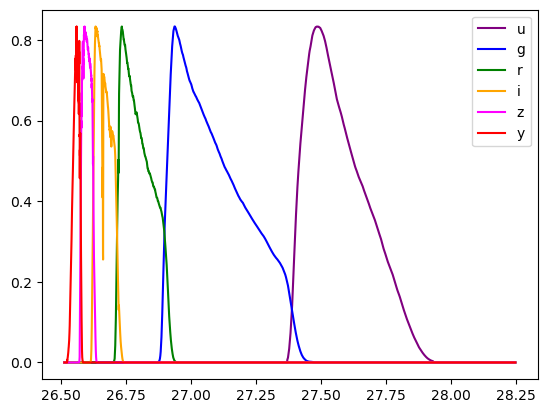

In [64]:
#Averaged (summed) and normalized dNdR distributions:

avg_dNdR = {}
for band, distribution in filtered_refracted_data.items():
    normalized_distributions = (distribution.T * (1/np.max(distribution, axis = 1)) / 1.2).T
    avg = np.mean(normalized_distributions, axis = 0) 
    avg = avg / np.max(avg) / 1.2
    avg_dNdR[band] = avg
    plt.plot(refraction_wave, avg, label = band, color = colors[band])

plt.legend()

In [66]:
#Matthew's method for calculating the total refraction across a band

def calculate_filter_refractions(filter_files, directory, airmasses, dcr = True, cutoff = 8005):
    
    wavelengths = np.linspace(300, 1100, 8000)
    zeniths = []
    for airmass in airmasses:
        if airmass > 0:
            zeniths.append(np.arccos(1 / airmass))
        else:
            zeniths.append(np.nan)  # handle zero or negative airmass values
    zeniths = np.degrees(zeniths) * u.deg
    # print(zeniths)

    gs_refractions = np.zeros((len(zeniths), len(wavelengths)))
    for i, zenith in enumerate(zeniths):
        gs_refraction = 3600 * np.rad2deg(galsim.dcr.get_refraction(
            wavelengths,
            zenith_angle=zenith.to_value(u.deg) * galsim.degrees,
            # pressure=70.0,  # kPa
            # temperature=293.15,  # K
            # H2O_pressure=0.0,  # kPa
            pressure=69.328,
            temperature=293.15,
            H2O_pressure=1.067,
        ))
        gs_refractions[i, :] = gs_refraction

    filter_refractions = []
    refraction_centers = []

    for i, filter_file in enumerate(filter_files):
        #Seems like this information about the filters should just be saved once and referred back to
        data = read_filter_data_from_directory(directory, filter_file)
        wavelength = data[:(cutoff + 1), 0]
        throughput = data[:(cutoff + 1), 1]
        fwhm, left_wavelength, right_wavelength, left_idx, right_idx = calculate_fwhm(wavelength, throughput)
        
        left_idx_new = find_nearest_index(wavelengths, left_wavelength)
        right_idx_new = find_nearest_index(wavelengths, right_wavelength)

        refraction_left = gs_refractions[:, left_idx_new]
        refraction_right = gs_refractions[:, right_idx_new]
        differential_refractions = abs(refraction_left - refraction_right) if dcr else np.zeros_like(airmasses)
        refraction_center = min([refraction_left, refraction_right]) + differential_refractions/2
        filter_refractions.append(differential_refractions)
        refraction_centers.append(refraction_center)
    return filter_refractions, refraction_centers

def find_nearest_index(array, value):
    return (np.abs(array - value)).argmin()

def calculate_fwhm(wavelength, throughput, cutoff = 8005):
    max_index = np.argmax(throughput)
    half_max = throughput[max_index] / 10 #may change to actual half maximum. This will calculate the range of the filter
    
    # left index where throughput drops below half max
    left_idx = max_index
    for i in range(max_index, 0, -1):
        if throughput[i] < half_max:
            left_idx = i
            break
    
    # right index where throughput drops below half max
    right_idx = 0
    j = cutoff #throughput becomes zeros past the value of cutoff = 8005
    while throughput[j] <= half_max:
            right_idx = j
            j -= 1
            if throughput[j] > half_max:
                break
    
    fwhm = wavelength[right_idx] - wavelength[left_idx]
    return fwhm, wavelength[left_idx], wavelength[right_idx], left_idx, right_idx

def read_filter_data_from_directory(directory, filter_file):
    file_path = os.path.join(directory, filter_file)
    data = np.loadtxt(file_path)
    return data


directory = 'filter_files' 
filter_files = ['total_u.dat', 'total_g.dat', 'total_r.dat', 'total_i.dat', 'total_z.dat', 'total_y.dat']

filter_refractions, refraction_centers = calculate_filter_refractions(filter_files, directory, [float(1/np.cos(35*u.deg))])

for i, filt in enumerate(filter_files):
    # print(filt,'full width', filter_refractions[i])
    print(filt, 'standard deviation: ', filter_refractions[i]/np.sqrt(12))

total_u.dat standard deviation:  [0.13829356]
total_g.dat standard deviation:  [0.15280521]
total_r.dat standard deviation:  [0.06195728]
total_i.dat standard deviation:  [0.03209461]
total_z.dat standard deviation:  [0.01709159]
total_y.dat standard deviation:  [0.012992]


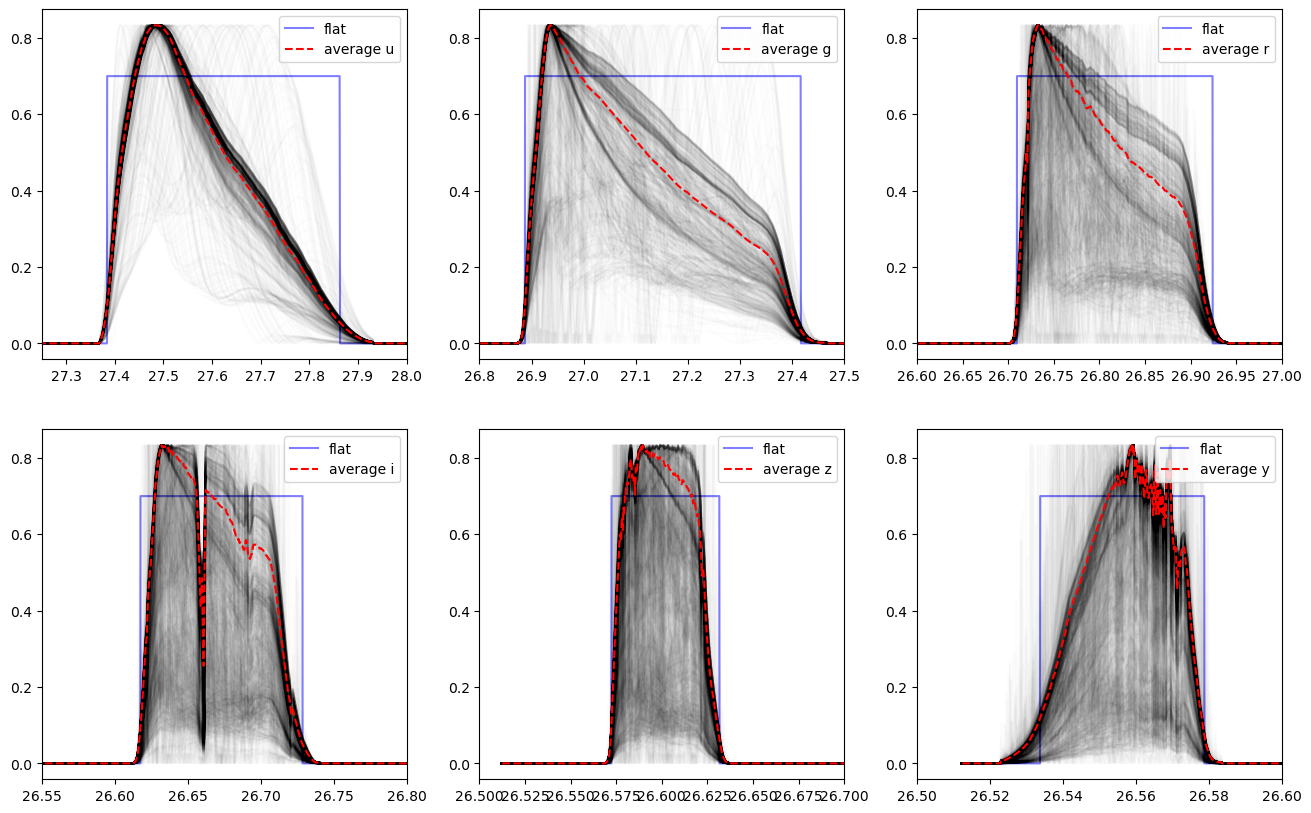

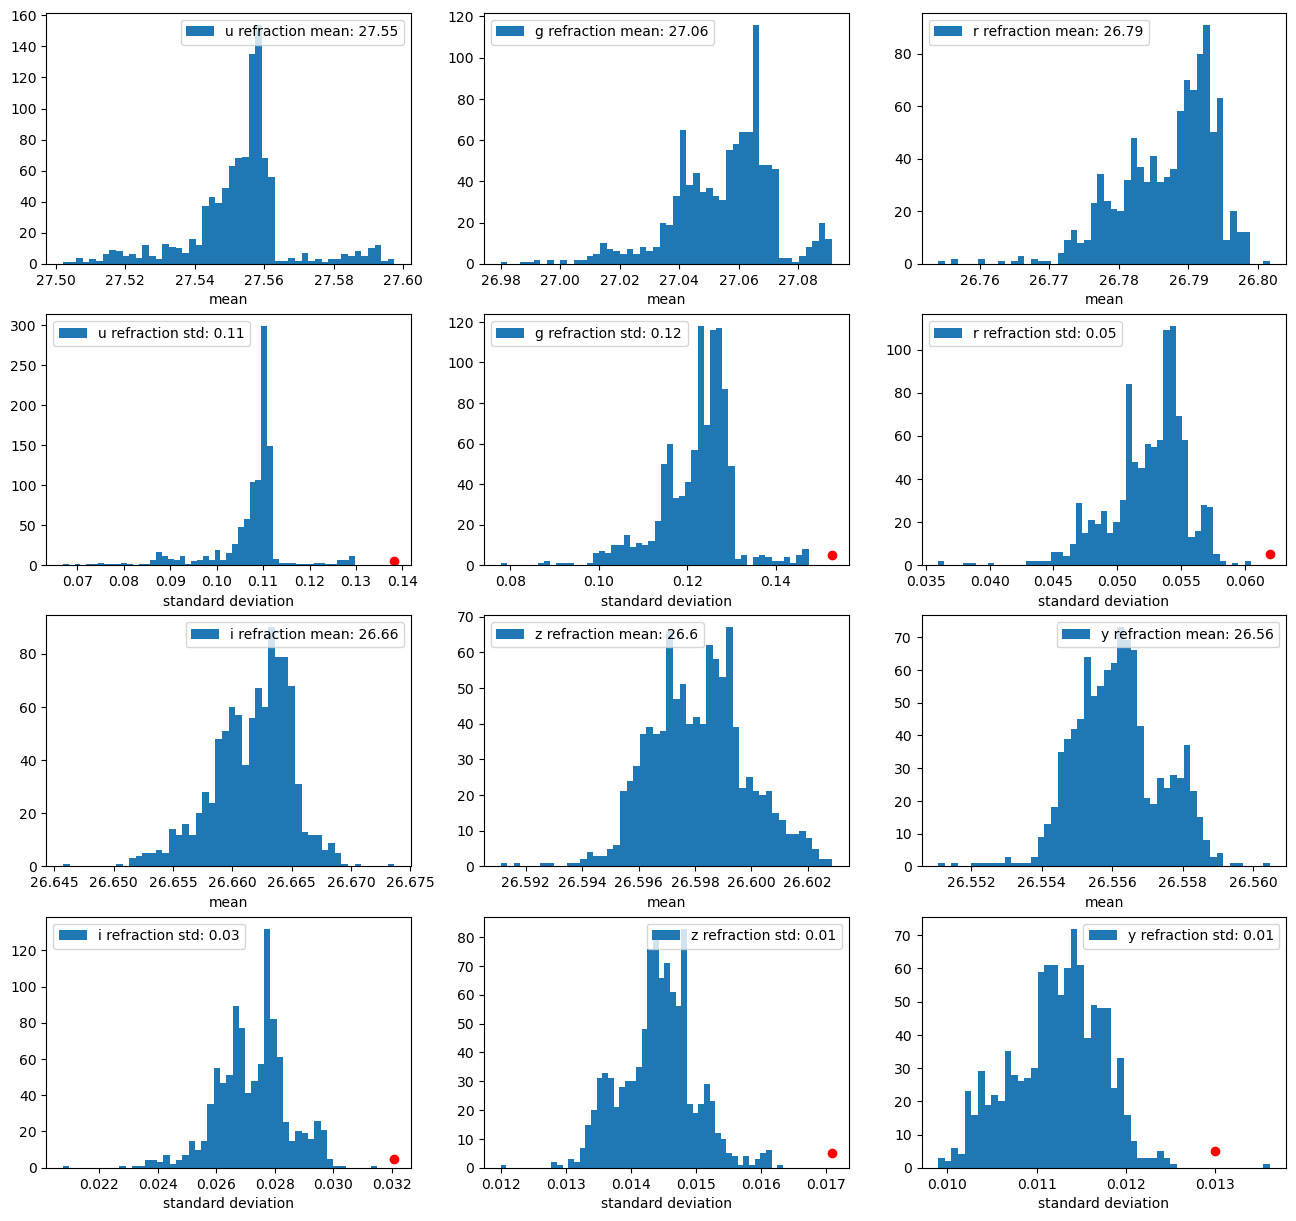

In [48]:
#Plots

mins = [27.25, 26.8, 26.6, 26.55, 26.5, 26.5]
maxs = [28, 27.5, 27, 26.8, 26.7, 26.6]

fig1, ax1 = plt.subplots(2, 3, figsize = (16, 10))

fig2, ax2 = plt.subplots(4, 3, figsize = (16, 15))

for i, band in enumerate(filter_labels):
    # fig = plt.figure(figsize = (8,6))
    

    #flat distribution 
    width = filter_refractions[i]
    center = refraction_centers[i]
    flat_dist = np.zeros(len(refraction_wave))
    mask = (refraction_wave > (center - width/2)) & (refraction_wave < (center + width/2))
    flat_dist[mask] = 0.7

    n = i // 3
    m = i % 3
    ax1[n, m].plot(refraction_wave, flat_dist, 'b-', label = 'flat', alpha = 0.5)

    #plot all 1000 distributions on top of each other with a small alpha 
    for dist in filtered_refracted_data[band]:
        normalized = np.abs(dist)/max(np.abs(dist))/1.2
        # summed += normalized
        ax1[n, m].plot(refraction_wave, normalized, 'k', alpha = 0.01)

    #plot the average distribution
    ax1[n, m].plot(refraction_wave, avg_dNdR[band], 'r--', label = f'average {band}')
    ax1[n, m].legend(loc = 'upper right')
    ax1[n, m].set_xlim(mins[i], maxs[i])
    

    #plot a histogram of the means and standard deviations for each filter
    hist, bins = np.histogram(means[band] - np.mean(means['u']), 20)
    ax2[n*2, m].hist(means[band], 50, label = f'{band} refraction mean: {np.round(np.mean(means[band]), 2)}')
    ax2[n*2, m].legend()
    ax2[n*2, m].set_xlabel('mean')
    ax2[n*2 + 1, m].hist(stdevs[band], 50, label = f'{band} refraction std: {np.round(np.mean(stdevs[band]), 2)}')
    ax2[n*2 + 1, m].plot(filter_refractions[i]/np.sqrt(12), 5, 'ro')
    ax2[n*2 + 1, m].legend()
    ax2[n*2 + 1, m].set_xlabel('standard deviation')
    
# fig1.savefig(f'refraction_dist_plots/all.png')
# fig1.savefig(f'refraction_dist_plots/all.pdf')


# fig2.savefig(f'refraction_dist_plots/all_histograms.png')
# fig2.savefig(f'refraction_dist_plots/all_histograms.pdf')
   